<a href="https://colab.research.google.com/github/tmmridho/hacktiv8/blob/main/PYIM_Final_Project_Teuku_Muhammad_Mifdhal_Ridho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**People Wearing Mask - Object Detection**

---

Dalam masa pandemi Covid-19 seperti sekarang, masker merupakan salah satu kebutuhan atau dapat dikatakan sebagai *equipment* wajib bagi setiap orang. Masker digunakan sebagai salah satu pencegahan penularan virus corona tipe Covid-19. Dan ***Object Detection*** yang dilakukan untuk mendeteksi orang menggunakan masker atau tidak. 
Dataset yang digunakan diambil dari **Roboflow** dimana berisi 149 gambar orang menggunakan masker yang sudah di-*masking* dalam format **tfrecord**.
Pada *notebook* ini akan ditunjukkan proses implementasi *object detection* menggunakan metode *transfer learning *dari *Object Detection Model* **Tensorflow** yaitu **SSD Mobilenet V2**

#**Persiapan**
Langkah ini dilakukan untuk menentukan versi tensorflow yang akan kita gunakan, yaitu versi 1.x.

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


Install package yang dibutuhkan, lakukan clone pada model tensorflow yang akan digunakan.

In [ ]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!pip install tf_slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install lvis

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.


/content
     |████████████████████████████████| 352 kB 7.8 MB/s 
Selecting previously unselected package python-bs4.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to un

Import library yang dibutuhkan dan test akses model yang telah di-clone.

In [ ]:
import os
from google.colab import files
import shutil
import glob
import urllib.request
import tarfile
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import io
import IPython.display
import PIL

In [ ]:
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

Lakukan konfigurasi dan definisikan variabel yang akan digunakan dalam melakukan transfer learning dan training.

In [ ]:
repo_url = 'https://github.com/tmmridho/hacktiv8'

num_steps = 30000  

num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    }, 
}

selected_model = 'ssd_mobilenet_v2'

# Model object detection yang akan digunakan.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Pipeline file yang akan digunakan pada tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

Cloning repository github yang sudah didefinisikan untuk menyamakan environment.

In [ ]:
%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'hacktiv8'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
/content/hacktiv8
Already up to date.


# **Data Loading and Preprocessing**


Arahkan direktori ke folder data, kemudian upload file dataset zip yang sudah didownload dari website roboflow dan lakukan unzip.

In [ ]:
%cd /content/hacktiv8/data

/content/hacktiv8/data


In [ ]:
object_detect = files.upload()

Saving mask.zip to mask.zip


In [ ]:
!unzip mask.zip

Archive:  mask.zip
 extracting: test/People.tfrecord    
 extracting: train/People.tfrecord   
 extracting: valid/People.tfrecord   
 extracting: test/People_label_map.pbtxt  
 extracting: train/People_label_map.pbtxt  
 extracting: valid/People_label_map.pbtxt  
 extracting: README.roboflow.txt     
 extracting: README.dataset.txt      


In [ ]:
# training set
%ls train

People_label_map.pbtxt  People.tfrecord


In [ ]:
# test set
%ls test

People_label_map.pbtxt  People.tfrecord


Definisikan data test, train, dan label dalam variabel.

In [ ]:
test_record_fname = '/content/hacktiv8/data/test/People.tfrecord'
train_record_fname = '/content/hacktiv8/data/train/People.tfrecord'
label_map_pbtxt_fname = '/content/hacktiv8/data/train/People_label_map.pbtxt'

Visualisasikan dataset tfrecord menggunakan library model object_detection yang sudah di-clone

/content/models/research
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


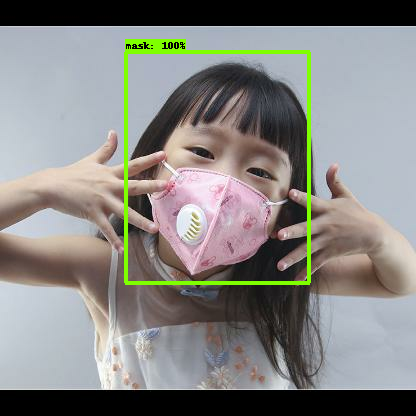

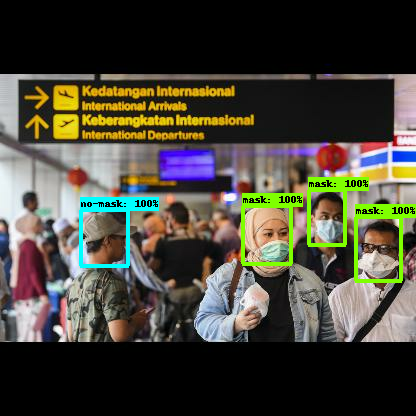

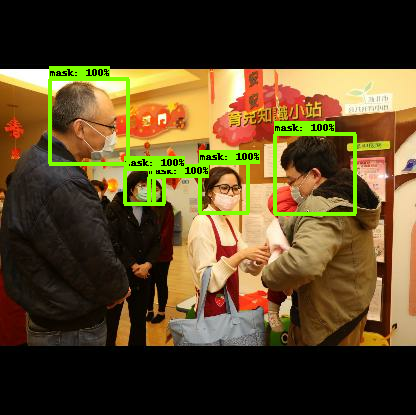

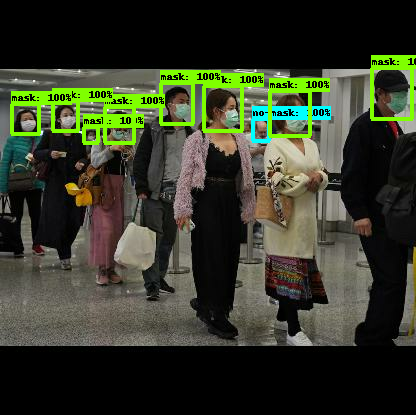

In [ ]:
%cd /content/models/research


from object_detection.utils import visualization_utils as vu
from object_detection.protos import string_int_label_map_pb2 as pb
from object_detection.data_decoders.tf_example_decoder import TfExampleDecoder as TfDecoder
from google.protobuf import text_format 
import itertools

%matplotlib inline

def visualise(tfrecords_filename, label_map=None):
    if label_map is not None:
        label_map_proto = pb.StringIntLabelMap()
        with tf.gfile.GFile(label_map,'r') as f:
            text_format.Merge(f.read(), label_map_proto)
            class_dict = {}
            for entry in label_map_proto.item:
                class_dict[entry.id] = {'name':entry.display_name}
    sess = tf.Session()
    decoder = TfDecoder(label_map_proto_file=label_map, use_display_name=False)
    sess.run(tf.tables_initializer())
    topN = itertools.islice(tf.python_io.tf_record_iterator(tfrecords_filename), 5)
    for record in topN:
        example = decoder.decode(record)
        host_example = sess.run(example)
        scores = np.ones(host_example['groundtruth_boxes'].shape[0])
        vu.visualize_boxes_and_labels_on_image_array( 
            host_example['image'],                                               
            host_example['groundtruth_boxes'],                                                     
            host_example['groundtruth_classes'],
            scores,
            class_dict,
            max_boxes_to_draw=None,
            use_normalized_coordinates=True)
        
        IPython.display.display(PIL.Image.fromarray(host_example['image']))

visualise(train_record_fname,label_map_pbtxt_fname)

# **Model Definition**

Download base model yang akan digunakan untuk melakukan transfer learning.

In [ ]:
%cd /content/models/research


MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 23 root   root  4.0K Jul 21 09:57 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [ ]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

Lakukan konfigurasi pipeline model

In [ ]:
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [ ]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=3, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [ ]:
num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [ ]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 2
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

In [ ]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

# **Model Training**


Pada bagian ini akan dilakukan training model berdasarkan model yang sudah ada menggunakan transfer learning.

In [ ]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0721 09:58:19.939986 140172474378112 model_lib.py:817] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 30000
I0721 09:58:19.940191 140172474378112 config_util.py:552] Maybe overwriting train_steps: 30000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0721 09:58:19.940281 140172474378112 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0721 09:58:19.940363 140172474378112 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0721 09:58:19.940442 140172474378112 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0721 09:58:19.940543 140172474378112 model_lib.py:833] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to

In [ ]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1626861514.c12a671ca4b6
export
graph.pbtxt
model.ckpt-20128.data-00000-of-00001
model.ckpt-20128.index
model.ckpt-20128.meta
model.ckpt-23004.data-00000-of-00001
model.ckpt-23004.index
model.ckpt-23004.meta
model.ckpt-25932.data-00000-of-00001
model.ckpt-25932.index
model.ckpt-25932.meta
model.ckpt-28815.data-00000-of-00001
model.ckpt-28815.index
model.ckpt-28815.meta
model.ckpt-30000.data-00000-of-00001
model.ckpt-30000.index
model.ckpt-30000.meta


# **Model Evaluation**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir 'training/'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# **Save Model**

Exporting Trained Inference Graph.

In [ ]:
output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-30000
Instructions for updating:
Please use `layer.__call__` method instead.
W0721 11:48:24.957285 140434371389312 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0721 11:48:26.976393 140434371389312 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0721 11:48:27.014696 140434371389312 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0721 11:48:27.050614 140434371389312 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:dep

In [ ]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


Download .pb file model.

In [ ]:
%cd /content/models/research

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

/content/models/research


Download konfigurasi model ke local system.

In [ ]:
files.download(pb_fname)
files.download(label_map_pbtxt_fname)
files.download(pipeline_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Model Inference**
Definisikan model dan file konfigurasi yang akan dipakai.

In [46]:
%cd /content/hacktiv8/data/test

# Arahkan direktori pb file. Model tersebut akan digunakan untuk menjalankan object detection.
PATH_TO_CKPT = pb_fname

# Arahkan konfigurasi label yang akan digunakan pada masing-masing indentifikasi box.
PATH_TO_LABELS = label_map_pbtxt_fname

# Upload images file ke PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR = "/content/hacktiv8/data/test/"
sample_img = files.upload()

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

/content/hacktiv8/data/test


Saving people-wearing-face-mask-for-protection-3957986-scaled.jpg to people-wearing-face-mask-for-protection-3957986-scaled.jpg
['/content/hacktiv8/data/test/mask-myths.jpg', '/content/hacktiv8/data/test/09_08_20downtown_masks-16.jpg', '/content/hacktiv8/data/test/im-362880.jpg', '/content/hacktiv8/data/test/people-wearing-face-mask-for-protection-3957986-scaled.jpg', '/content/hacktiv8/data/test/People_label_map.pbtxt', '/content/hacktiv8/data/test/People.tfrecord']


Arahkan direktori ke model object_detection, import library yang dibutuhkan, dan gunakan utilitas model object_detection.

In [47]:
%cd /content/models/research/object_detection

import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/models/research/object_detection


Definisikan fungsi dan jalankan.

In [48]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [49]:
# Dibutuhkan untuk menampilkan gambar.
%matplotlib inline

/content/hacktiv8/data/test/mask-myths.jpg


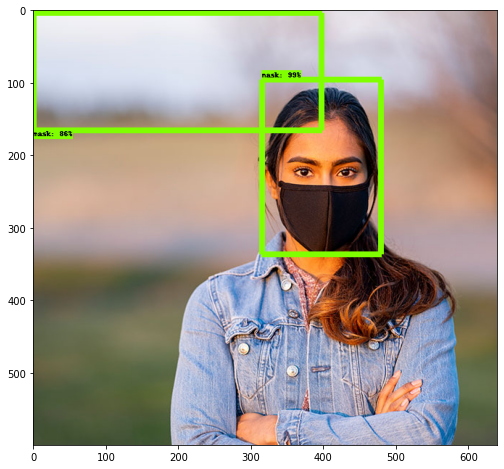

/content/hacktiv8/data/test/09_08_20downtown_masks-16.jpg


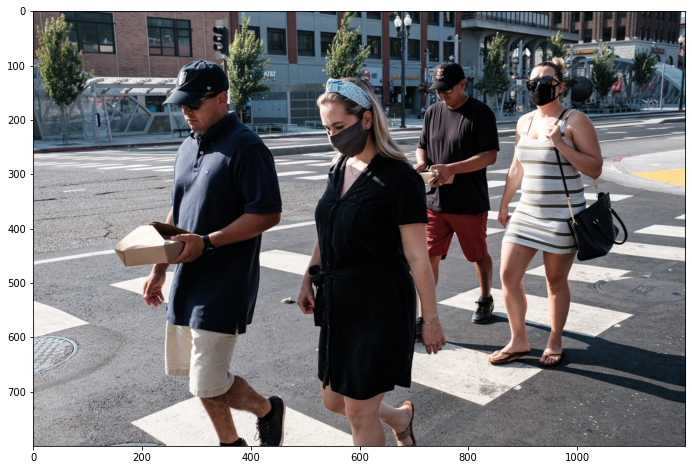

/content/hacktiv8/data/test/im-362880.jpg


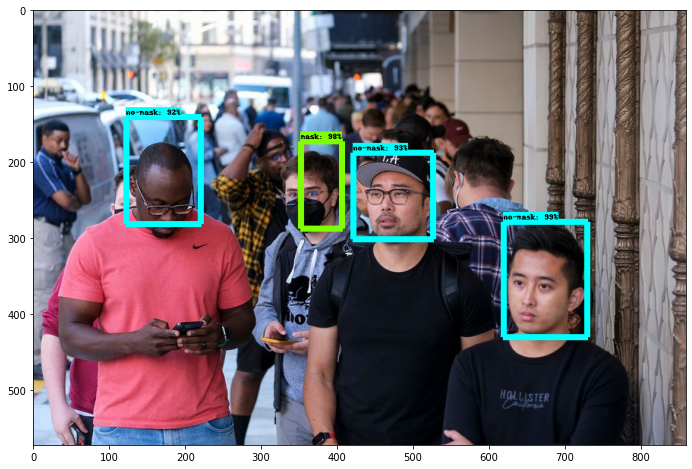

/content/hacktiv8/data/test/people-wearing-face-mask-for-protection-3957986-scaled.jpg


In [50]:
for image_path in TEST_IMAGE_PATHS:
  try:
    image = Image.open(image_path)
    print(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()
  except Exception:
    pass

# **Kesimpulan**

---
Dengan mengimplementasikan *object detection* menggunakan metode *transfer learning* dari model **SSD Mobilenet V2 Tensorflow** akan mempermudah dalam melakukan training model terhadap dataset dengan waktu yang cenderung lebih singkat.Dimana model yang telah di-training tersebut dapat digunakan untuk mendeteksi orang menggunakan masker atau tidak, sebagai tindakan preventif penularan virus Covid-19 selama masa pandemi Covid-19.
